# Semanti Segmentation for self driving cars

![Enet_prediction.png](images/Enet_prediction.png)

In this project I will use semantic segmentation technique to identify road and cars in images.
More specifically, I will compare [ENET model](https://arxiv.org/pdf/1606.02147.pdf) and [SEGNET model](https://arxiv.org/pdf/1511.00561.pdf) and see which one performs better in terms of speed and [mean IOU](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) accuracy, for a better understanding I encorage you to check my report.

In [1]:
from PrePostProcessing import convert_segmentation
from numpy.random import randint
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import os

%matplotlib inline

# used to reproduce the same random numbers
np.random.seed(445)

## Images and masks full paths

In [2]:
image_path, mask_path = 'input/dataA/CameraRGB', 'input/dataA/CameraSeg'

image_list = [os.path.join(image_path, img) for img in os.listdir(image_path)]
mask_list = [os.path.join(mask_path, img) for img in os.listdir(mask_path)]

## Visualize some examples of the dataset
Segmentation masks contain low red color intensity, to better visualize them we need to convert these values.
#### note: check 'PrePostProcessing.convert_segmentation' for a better understanding on how it is done

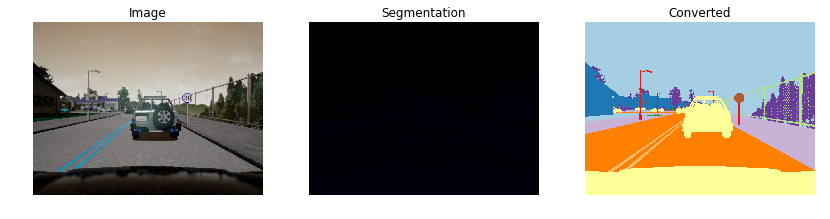

In [3]:
N = randint(0, len(image_list))
img = cv2.imread(image_list[N])
mask = cv2.imread(mask_list[N])
converted = convert_segmentation(mask)

fig, arr = plt.subplots(1, 3, figsize=(14, 10))
arr[0].imshow(img)
arr[0].axis("off")
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].axis("off")
arr[1].set_title('Segmentation')
arr[2].imshow(converted.reshape(*img.shape[:2]), cmap='Paired')
arr[2].axis("off")
arr[2].set_title('Converted')
plt.show()

## Visualize mean, standard deviation and variance using 4x4 kernel

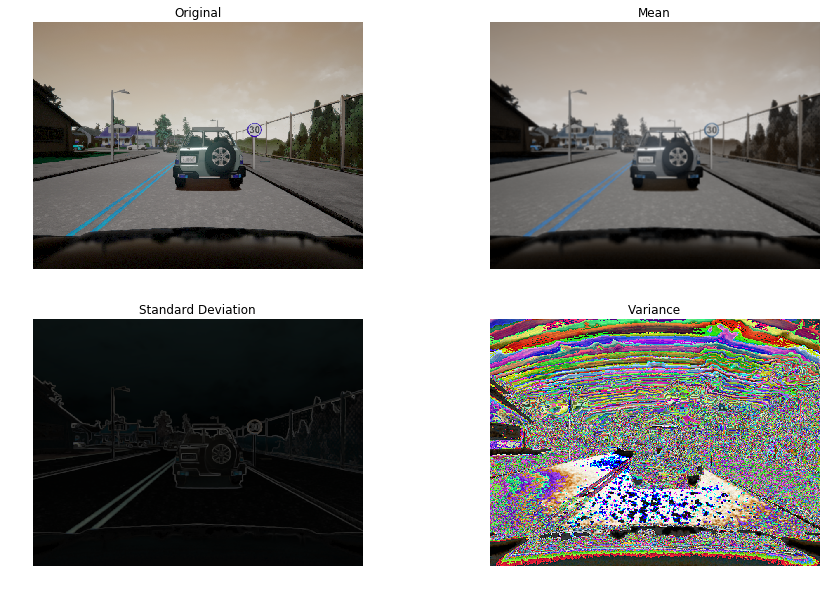

In [6]:
from scipy import ndimage 
rows, cols = img.shape[:2]
win_rows, win_cols = 4, 4

win_mean = ndimage.uniform_filter(img, (win_rows, win_cols, 3))
win_sqr_mean = ndimage.uniform_filter(img**2, (win_rows, win_cols, 3))
win_std = ndimage.filters.generic_filter(img, np.std, size=4)
win_var = win_sqr_mean - win_mean**2

fig, arr = plt.subplots(2, 2, figsize=(15, 10))
arr[0][0].imshow(img)
arr[0][0].axis("off")
arr[0][0].set_title('Original')
arr[0][1].imshow(win_mean)
arr[0][1].axis("off")
arr[0][1].set_title('Mean')
arr[1][0].imshow(win_std)
arr[1][0].axis("off")
arr[1][0].set_title('Standard Deviation')
arr[1][1].imshow(win_var)
arr[1][1].axis("off")
arr[1][1].set_title('Variance')
plt.show()

## Load images and masks from dataset

Only images containing cars will be loaded by using the 'car_present' function.
Images and masks will be cropped in order to cut the lower part of the image and the upper part.
'Create_masks' extract only the masks refering to the road and the cars.
#### note: 'create_masks' takes care of selecting only the masks relating to road and cars

In [4]:
from PrePostProcessing import preprocess, create_masks, car_present


# DO NOT CHANGE THIS NUMBER, this is the number of usable images in the dataset
MAX_LENGTH = 255

height, width = 320, 800

# images used for training
images = np.zeros((MAX_LENGTH, height, width, 3), dtype=np.int16)
# ground truth
masks = np.zeros((MAX_LENGTH, height, width, 2), dtype=np.int8)

counter = 0
for n in tqdm(range(len(image_list))):
    if counter == MAX_LENGTH:
        break
    mask = cv2.imread(mask_list[n])
    if not car_present(mask):
        continue
    images[counter] = preprocess(cv2.imread(image_list[n]))
    masks[counter] = create_masks(mask)
    counter += 1


assert(counter==MAX_LENGTH), "There are {} empty arrays in 'images' and 'masks'!".format(abs(MAX_LENGTH - counter))

100%|██████████| 1000/1000 [00:12<00:00, 78.24it/s]


## Split data into training, validation and test sets

In [5]:
from sklearn.model_selection import train_test_split


train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.35)
test_images, test_masks = val_images[50:], val_masks[50:]
val_images, val_masks = val_images[:50], val_masks[:50]

del images, masks

test_masks = test_masks.reshape(test_masks.shape[0], height * width, 2)
val_masks = val_masks.reshape(val_masks.shape[0], height * width, 2)

## Visualize some augmented images

For a better generalization, the images are randomly shifted, flipped and rotated.
Contrast and brightness are also modified.

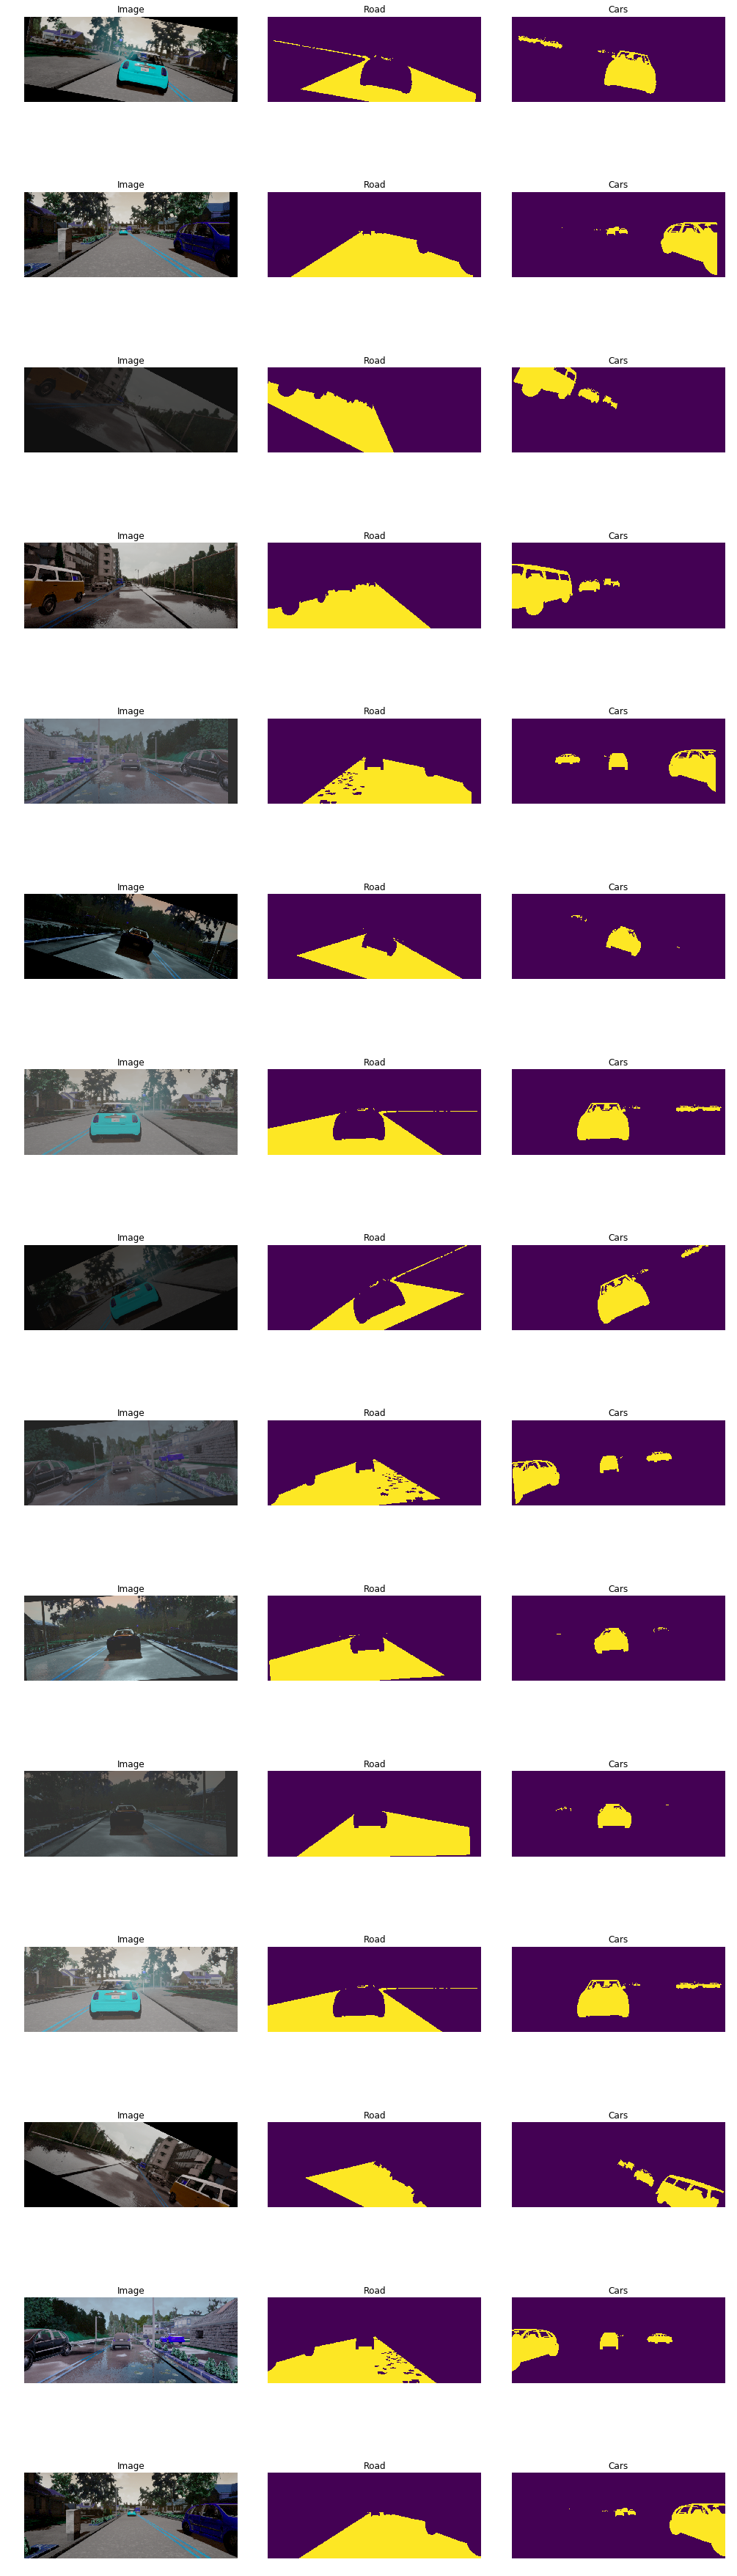

In [6]:
from CustomAugmentation import custom_generator


NUMBER = randint(0, train_images.shape[0])

fig, axs = plt.subplots(nrows=15, ncols=3, figsize=(14, 50))
fig.tight_layout()

for i, (image, masks) in enumerate(custom_generator(train_images[NUMBER : NUMBER + 5], 
                                                    train_masks[NUMBER : NUMBER + 5], batch_size=1)):
    if i >= 45:
        break
    
    # reshape images for display
    image = image.reshape(height, width, 3)
    masks = masks.reshape(2, height, width)
    road_mask, cars_mask = masks[0], masks[1]
    
    # images
    axs[i//3][0].imshow(image)
    axs[i//3][0].axis("off")
    axs[i//3][0].set_title('Image')
    
    # roads
    axs[i//3][1].imshow(road_mask)
    axs[i//3][1].axis("off")
    axs[i//3][1].set_title('Road')
    
    # cars
    axs[i//3][2].imshow(cars_mask)
    axs[i//3][2].axis("off")
    axs[i//3][2].set_title('Cars')

In [7]:
print("Images: ", train_images.shape, val_images.shape, test_images.shape)
print("Masks: ", train_masks.shape, val_masks.shape, test_masks.shape)

Images:  (165, 320, 800, 3) (50, 320, 800, 3) (40, 320, 800, 3)
Masks:  (165, 320, 800, 2) (50, 256000, 2) (40, 256000, 2)


## Build all models used in this project

Enet and SEGNET models are the original models, 'ENET small' has fewer filters and 2 more layers for resizing the image which result in faster performance.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from Models import Segnet, Enet

### Original ENET model

In [9]:
enet_model = Enet(2, train_images[0].shape).model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 400, 13) 364         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 160, 400, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 160, 400, 16) 0           conv2d[0][0]                     
                                                                 max_pooling2d[0][0]              
__________

### ENET model with less filters

In [10]:
enet_model_small = Enet(2, train_images[0].shape, optimized=True).model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 800, 3)  0                                            
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 80, 200, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 40, 100, 13)  364         max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 40, 100, 3)   0           max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
concatenat

### SEGNET model

In [11]:
segnet_model = Segnet(2, train_images[0].shape).model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 320, 800, 3)       0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 320, 800, 16)      448       
_________________________________________________________________
batch_normalization_162 (Bat (None, 320, 800, 16)      64        
_________________________________________________________________
activation_2 (Activation)    (None, 320, 800, 16)      0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 320, 800, 16)      2320      
_________________________________________________________________
batch_normalization_163 (Bat (None, 320, 800, 16)      64        
_________________________________________________________________
activation_3 (Activation)    (None, 320, 800, 16)      0         
__________

### Here you can see the huge difference of trainable parameters of the 3 models

- ENET: 358,322    
- ENET small: 204,754   
- SEGNET: 4,501,906

## Training the models

#### note: use the commented cells to use generators instead of images loaded into the RAM

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(patience=6, verbose=1),
    ModelCheckpoint('Weights/ENET.h5', verbose=1, save_best_only=True)
]

enet_results = enet_model.fit_generator(custom_generator(train_images, train_masks, batch_size=4), 
                                        epochs=100, steps_per_epoch=2000, callbacks=callbacks, 
                                        validation_data=(val_images, val_masks))

In [12]:
enet_model = Enet(2, train_images[0].shape, show_summary=False).model

In [13]:
enet_model.load_weights('Weights/ENET.h5')

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(patience=6, verbose=1),
    ModelCheckpoint('Weights/ENET_small.h5', verbose=1, save_best_only=True)
]

small_enet_results = enet_model_small.fit_generator(custom_generator(train_images, train_masks, batch_size=4), 
                                                    epochs=100, steps_per_epoch=2000, callbacks=callbacks, 
                                                    validation_data=(val_images, val_masks))

In [14]:
enet_model_small = Enet(2, train_images[0].shape, optimized=True, show_summary=False).model

In [15]:
enet_model_small.load_weights('Weights/ENET_small.h5')

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(patience=6, verbose=1),
    ModelCheckpoint('Weights/SEGNET.h5', verbose=1, save_best_only=True)
]

segnet_results = segnet_model.fit_generator(custom_generator(train_images, train_masks, batch_size=4), 
                                            epochs=100, steps_per_epoch=2000, callbacks=callbacks, 
                                            validation_data=(val_images, val_masks))

In [16]:
segnet_model = Segnet(2, train_images[0].shape, show_summary=False).model

In [17]:
segnet_model.load_weights('Weights/SEGNET.h5')

## Visualize performance during training

In [ ]:
fig, arr = plt.subplots(3, 2, figsize=(12, 15))

arr[0][0].plot(enet_results.history["loss"])
arr[0][0].plot(enet_results.history["val_loss"])
arr[0][0].legend(["training", "validation"])
arr[0][0].set_title("ENET Model loss")
arr[0][0].set_xlabel("epoch")

arr[0][1].plot(enet_results.history["mean_iou"])
arr[0][1].plot(enet_results.history["val_mean_iou"])
arr[0][1].legend(["training", "validation"])
arr[0][1].set_title("ENET Model mean_iou")
arr[0][1].set_xlabel("epoch")

arr[1][0].plot(small_enet_results.history["loss"])
arr[1][0].plot(small_enet_results.history["val_loss"])
arr[1][0].legend(["training", "validation"])
arr[1][0].set_title("ENET less filters loss")
arr[1][0].set_xlabel("epoch")

arr[1][1].plot(small_enet_results.history["mean_iou"])
arr[1][1].plot(small_enet_results.history["val_mean_iou"])
arr[1][1].legend(["training", "validation"])
arr[1][1].set_title("ENET less filters mean_iou")
arr[1][1].set_xlabel("epoch")

arr[2][0].plot(segnet_results.history["loss"])
arr[2][0].plot(segnet_results.history["val_loss"])
arr[2][0].legend(["training", "validation"])
arr[2][0].set_title("SEGNET Model loss")
arr[2][0].set_xlabel("epoch")

arr[2][1].plot(segnet_results.history["mean_iou"])
arr[2][1].plot(segnet_results.history["val_mean_iou"])
arr[2][1].legend(["training", "validation"])
arr[2][1].set_title("SEGNET Model mean_iou")
arr[2][1].set_xlabel("epoch")

plt.show()

![Plot.png](images/Plot.png)

## Visual comparison between the 3 models and the ground truth

In [18]:
NUMBER = 0

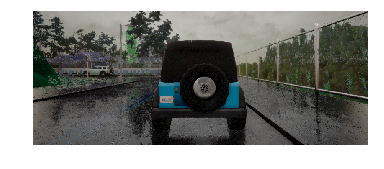

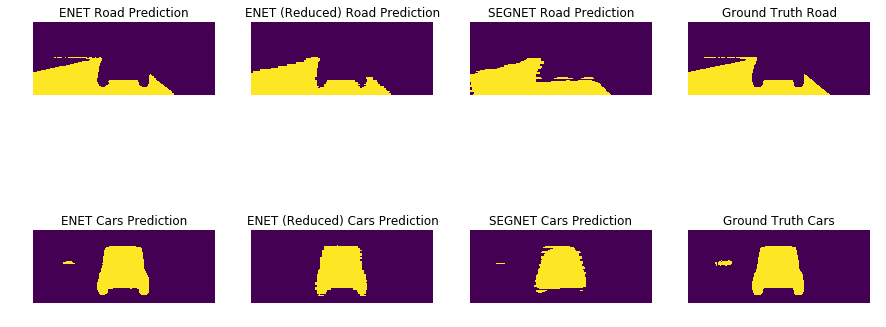

In [19]:
from PrePostProcessing import convert_prediction


enet_predictions = convert_prediction(enet_model.predict(test_images[NUMBER].reshape(1, height, width, 3)))
enet_small_preds = convert_prediction(enet_model_small.predict(test_images[NUMBER].reshape(1, height, width, 3)))
segnet_predictions = convert_prediction(segnet_model.predict(test_images[NUMBER].reshape(1, height, width, 3)))

plt.imshow(test_images[NUMBER])
plt.axis("off")
fig, arr = plt.subplots(2, 4, figsize=(15, 7))
for i, t in enumerate(("Road", "Cars")):
    arr[i][0].imshow(enet_predictions[i])
    arr[i][0].axis("off")
    arr[i][0].set_title(f"ENET {t} Prediction")
    arr[i][1].imshow(enet_small_preds[i])
    arr[i][1].axis("off")
    arr[i][1].set_title(f"ENET (Reduced) {t} Prediction")
    arr[i][2].imshow(segnet_predictions[i])
    arr[i][2].axis("off")
    arr[i][2].set_title(f"SEGNET {t} Prediction")
    arr[i][3].imshow(test_masks[NUMBER].reshape(2, height, width)[i])
    arr[i][3].axis("off")
    arr[i][3].set_title(f"Ground Truth {t}")
plt.show()
NUMBER += 1

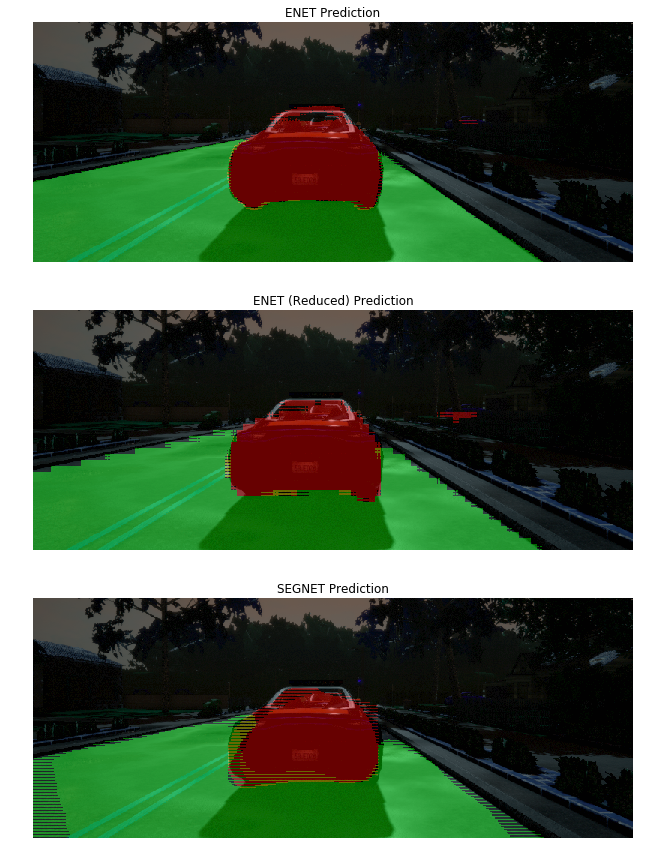

In [20]:
from helper import show_segmentation


NUMBER = randint(0, test_images.shape[0])

fig, arr = plt.subplots(3, 1, figsize=(15, 15))
arr[0].imshow(show_segmentation(test_images[NUMBER], enet_model))
arr[0].axis("off")
arr[0].set_title(f"ENET Prediction")
arr[1].imshow(show_segmentation(test_images[NUMBER], enet_model_small))
arr[1].axis("off")
arr[1].set_title(f"ENET (Reduced) Prediction")
arr[2].imshow(show_segmentation(test_images[NUMBER], segnet_model))
arr[2].axis("off")
arr[2].set_title(f"SEGNET Prediction")
plt.show()

## Benchmarks

#### Run this cell twice if no training was done

In [22]:
from Benchmarking import accuracy_mean_iou, speed


enet_accuracy, segnet_accuracy, small_enet_acc = accuracy_mean_iou(test_images, test_masks, 
                                                                   enet_model, segnet_model, enet_model_small)
enet_accuracy *= 100
small_enet_acc *= 100
segnet_accuracy *= 100
print(f"ACCURACY\nENET: {enet_accuracy:.2f}%\nENET (Reduced): {small_enet_acc:.2f}%\nSEGNET: {segnet_accuracy:.2f}%")

n_images = test_images.shape[0]
ripetitions = 10

enet_speed, segnet_speed = np.zeros(ripetitions, dtype=np.float32), np.zeros(ripetitions, dtype=np.float32)
reduced_enet_speed = np.zeros(ripetitions, dtype=np.float32)

for i in range(ripetitions):
    enet_speed[i], segnet_speed[i], reduced_enet_speed[i] = speed(test_images, enet_model, segnet_model, 
                                                                  enet_model_small)

print(f"\nENET speed: {enet_speed.mean() / n_images * 1000:.2f}ms")
print(f"ENET (Reduced) speed: {reduced_enet_speed.mean() / n_images * 1000:.2f}ms")
print(f"SEGNET speed: {segnet_speed.mean() / n_images * 1000:.2f}ms")

ACCURACY
ENET: 96.18%
ENET (Reduced): 93.99%
SEGNET: 85.04%

ENET speed: 31.47ms
ENET (Reduced) speed: 5.29ms
SEGNET speed: 31.29ms
